In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2025-11-05 05:59:57.619405


In [2]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models

In [ ]:
!gdown http://drive.google.com/uc?id=1ouBy3uqCMQlInsYBSyjTC3_ZBGXUoR7p
!gdown http://drive.google.com/uc?id=1Jt7QW3Lq1q3-PRfilS2Z2Hu47OVRBzyN
!gdown http://drive.google.com/uc?id=1obQiA0BeQdV0RxXdNyUuXKqNK0mGZpNn

!unzip -q "/content/SemanticSegmentation.zip" -d "/content/lab"

### What is Semantic Segmentation?
#### Semantic segmentation is an approach to understand what is in the image in pixel-level:

- It is a lot more difficult than image classification, which makes a prediction in image-level.

- It differs from object detection in that it has no information about instances.

<img src="https://drive.google.com/uc?export=view&id=1Oe6OVIuT8WPxK4x0LXOunxL-tVtzg948" alt="no_image" style="width: 900px;"/>

Applications for semantic segmentation include:

- Autonomous driving

- Image Editing

- Classification of terrain visible in satellite imagery

- Medical imaging analysis

### 1. Semantic segmentation with CNNs
- Typical classification models (AlexNet, VGGNet, ...) take fixed-sized inputs and produce a probability vector. The fully connected layers of these models have fixed dimensions and throw away spatial coordinates.


- It is known that the fully connected layer can be viewed as a convolution layer with a kernel that covers only one pixel, that is, a 1x1 kernel. Thus, we can convert the fully connected layers into convolution layers with maintaining pre-trained weights.


- After 'convolutionalizing' fully connected layers, a feature map needs to be upsampled because of pooling operations in the models. Instead of using simple bilinear interpolation, we can use a transposed convolution layer to learn the interpolation process. This layer is also called as upconvolution, deconvolution or fractionally-strided convolution.

### 1.1 Pixel wise classification using sliding window

<img src="https://drive.google.com/uc?export=view&id=1RJOmD22NyRT-6T0hCQ5hbU3FB9Mpevyu" alt="no_image" style="width: 900px;"/>

### 1.1.1 Example with VGG-Net

**Load a test image**

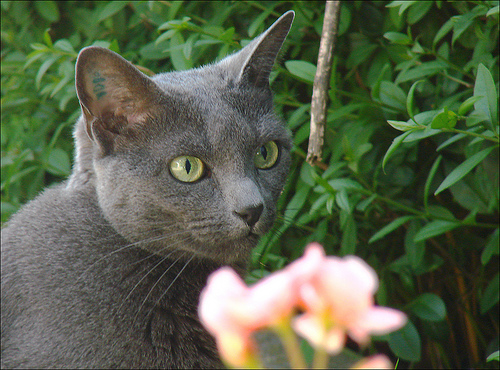

In [4]:
from PIL import Image
test_img_path = './2009_005160.jpg'
test_img = Image.open(test_img_path)
test_img

**Standardization of the test image**

In [5]:
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

test_transform = transform(test_img).cuda().unsqueeze(0)
print(test_transform.size())

torch.Size([1, 3, 224, 224])


**Load VGG-Net**

In [6]:
import torchvision.models.vgg as vgg
imageNet = vgg.vgg16(pretrained=True).cuda()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 98.4MB/s]


In [7]:
import torch
import torch.nn as nn
with torch.no_grad():
    out = imageNet(test_transform)

out_class = torch.argmax(out)
print(out.size())
print(out_class) # 285 is egyptian cat in ImageNet

torch.Size([1, 1000])
tensor(285, device='cuda:0')


In [8]:
# padding
m = nn.ZeroPad2d((111,112,111,112))
pad_image = m(test_transform)
res = torch.zeros((224,224)).cuda()

In [9]:
# sliding window approach for segmentation
# NOTICE: It takes some time
for i in range(224):
    for j in range(224):
        patch = pad_image[:,:,i:i+224,j:j+224]
        # classify each pixels
        with torch.no_grad():
            res[i,j] = torch.argmax(imageNet(patch))

In [10]:
print(res)

tensor([[285., 285., 285.,  ...,  24., 285., 282.],
        [285., 285., 285.,  ..., 285.,  24., 285.],
        [285., 285., 285.,  ..., 281.,  24., 285.],
        ...,
        [285., 360., 360.,  ..., 254., 254., 254.],
        [285., 286., 286.,  ..., 254., 299., 674.],
        [286., 285., 285.,  ..., 254., 384., 738.]], device='cuda:0')


**Visualize the output, classified as 'egyptian cat' (285)**

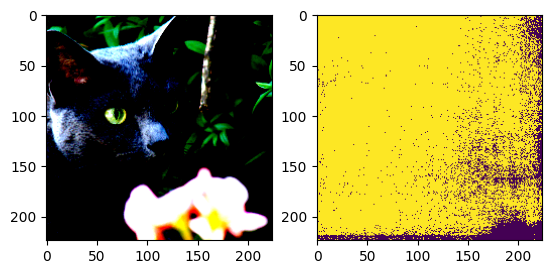

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(1,2,1)
plt.imshow(test_transform[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow((res==285).data.cpu().numpy()) # Visualize pixels classified as egyptian cat
plt.show()

- Inefficient & Ineffective !

### 1.2 Pixel wise classification using image classification

<img src="https://drive.google.com/uc?export=view&id=1XaspEEpplLzpNJ8qJpPN24qMeVmbsp5P" alt="no_image" style="width: 900px;"/>

#### 1.2.1 Convolutional VGG

In [12]:
import torchvision.models as models

class ConvolutionalVGG(nn.Module):
    def __init__(self):
        super(ConvolutionalVGG, self).__init__()
        self.features = models.vgg16(pretrained=True).features

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc8
        self.fc8 = nn.Conv2d(4096, 1000, 1)

        self.copy_params_from_vgg16()

    def forward(self, x):
        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)

        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)

        score = self.fc8(fc8)

        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3, 6], ['fc6', 'fc7', 'fc8']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [13]:
conv_vgg = ConvolutionalVGG().cuda()
conv_vgg

ConvolutionalVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [14]:
transform_conv = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

In [15]:
test_conv = transform_conv(test_img).cuda().unsqueeze(0)
print(test_conv.size())

torch.Size([1, 3, 370, 500])


In [16]:
conv_out = conv_vgg(test_conv)
pred = torch.argmax(conv_out, dim=1)
pred

tensor([[[285, 284, 284, 284, 284, 285, 285, 285, 281],
         [284, 284, 284, 284, 284, 284, 287, 284, 285],
         [284, 284, 284, 284, 284, 287, 287, 287, 287],
         [284, 284, 284, 284, 284, 284, 284, 284, 285],
         [284, 284, 284, 284, 284, 281, 852, 852, 285]]], device='cuda:0')

Although modifying VGG-Net to fully convolutional network results in a pixel-wise ouput, the output resolution is smaller than the original image resolution. Moreover, we can see that many pixels are misclassified (i.e., not 285).

#### 1.2.2 Add simple upsampling layer (Bilinear) and retrain with PASCAL VOC 2012
- Re-define the last layer so as to classify classes in the PASCAL VOC datasets
- Use bilinear interpolation to make the network output equal to the input size

In [ ]:
import torchvision.models as models

class ConvolutionalVGGwithUpsample(nn.Module):
    def __init__(self):
        super(ConvolutionalVGGwithUpsample, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.features[0].padding = (100,100)

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc8
        # PASCAL VOC 21개 클래스(20개 + 배경 1개) 에 맞게 마지막 레이어를 1x1 Conv로 재정의
        self.fc8 = nn.Conv2d(4096, 21, 1)

        ## Upsampling layer

        self.copy_params_from_vgg16()


    def forward(self, x):
        # 원본 입력 이미지의 높이(h)와 너비(w)를 저장
        h, w = x.shape[2], x.shape[3]

        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)

        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)

        score = self.fc8(fc8)
        
        # Upsample to original resolution
        # score 맵을 원본 입력(x)의 크기(h, w)와 동일하게 bilinear 방식으로 업샘플링
        score = nn.functional.interpolate(score, size=x.size()[2:], mode='bilinear', align_corners=False)

        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [18]:
conv_vgg_upsample = ConvolutionalVGGwithUpsample().cuda()

In [19]:
def decode_labels(mask, num_classes=21):
    from PIL import Image
    label_colours = [(0, 0, 0)
                 # 0=background
                 , (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128)
                 # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                 , (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0)
                 # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                 , (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128)
                 # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                 , (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]
                 # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor

    h, w = mask.shape

    img = Image.new('RGB', (w, h))
    pixels = img.load()
    for j_, j in enumerate(mask[:, :]):
        for k_, k in enumerate(j):
            if k < num_classes:
                pixels[k_, j_] = label_colours[k]
    output = np.array(img)

    return output

In [20]:
model_data = torch.load('vgg_conv_upsample.pth')
conv_vgg_upsample.load_state_dict(model_data)

<All keys matched successfully>

In [21]:
with torch.no_grad():
    conv_out = conv_vgg_upsample(test_conv)
output = torch.argmax(conv_out, dim=1)

vis_output = decode_labels(output[0].data.cpu().numpy())

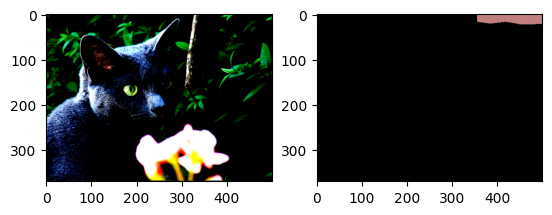

In [22]:
plt.subplot(1,2,1)
plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(vis_output)

### 1.3 Upsampling method with CNNs

#### Transposed Convolution

<img src="https://drive.google.com/uc?export=view&id=1olTrk2Hu1dAppF2zxFVedy0aIrAbYrAw"  onerror="this.style.display='none'" /><br><br>

- The transposed convolution (it is often called as "deconvolution") is used to up-sample the input resolution by using learnable filters. In contrast to the standard convolution, which aggregates spatial information to a single point, it spreads a point of the input over multiple spatial locations.
- For example, a $3\times3$ kernel with a stride of 2 converts the~$2\times2$~(cyan squares) input into the~$5\times5$~(blue squares) output.

## 2. Semantic segmentation

### 2.1 FCN8s model

<img src="https://drive.google.com/uc?export=view&id=1fBpZDHC-faw_-bPeMGOJ9cWR7D3S_g7P"  onerror="this.style.display='none'" /><br><br>


<p style='text-align:right;'>[<a href='https://medium.com/@wilburdes/semantic-segmentation-using-fully-convolutional-neural-networks-86e45336f99b'>source</a>]</p>

**Crop boundary example**

In [23]:
a = torch.ones((1, 1, 160, 140))
b = torch.ones((1, 1, 120, 120))

try:
    a + b
except:
    print('The size of tensors are different')
    print(a.size())
    print(b.size())

# crop boundary
a = a[:, :, 5: 5+b.size(2), 5:5+b.size(3)]

# add connection with weight
c = 0.01*a + b

The size of tensors are different
torch.Size([1, 1, 160, 140])
torch.Size([1, 1, 120, 120])


- Predict 1: $1\times1$ Conv(in: 4096, out: n_class)
- Predict 2: $1\times1$ Conv(in: 512, out: n_class), weight = 0.01
- Predict 3: $1\times1$ Conv(in: 256, out: n_class), weight = 0.0001

- Deconv 1: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 2: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 3: $16\times16$ Transposed Conv (in: n_class, out: n_class, stride: 8, biase: False)

In [ ]:
class FCN8s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # VGG features
        self.features = models.vgg16(pretrained=True).features

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7, padding=3)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # Predict 1 (from fc7/Pool5, in: 4096 -> out: n_class)
        self.score_fr = nn.Conv2d(4096, n_class, 1)

        # Predict 2 (from Pool4, in: 512 -> out: n_class)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)

        # Predict 3 (from Pool3, in: 256 -> out: n_class)
        self.score_pool3 = nn.Conv2d(256, n_class, 1)

        # Deconv 1 (in: n_class, out: n_class, kernel: 4, stride: 2)
        self.upscore2 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)

        # Deconv 2 (in: n_class, out: n_class, kernel: 4, stride: 2)
        self.upscore4 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)

        # Deconv 3 (in: n_class, out: n_class, kernel: 16, stride: 8)
        self.upscore8 = nn.ConvTranspose2d(n_class, n_class, 16, stride=8, bias=False)

        self._initialize_weights()
        self.copy_params_from_vgg16()

    def _initialize_weights(self):
        self.features[0].padding = (100,100)

        for m in self.modules():
            if isinstance(m, nn.MaxPool2d):
                m.ceil_mode=True
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        # 0. 원본 입력 크기 저장
        input_size = x.size()

        # 1. VGG 특징 추출 및 중간 결과 (Pool3, Pool4, Pool5) 저장
        # VGG16 features의 레이어 인덱스를 사용해 중간 결과 획득
        # Pool3: features[:17]
        h = self.features[:17](x)
        pool3 = h

        # Pool4: features[17:24]
        h = self.features[17:24](h)
        pool4 = h

        # Pool5: features[24:31]
        h = self.features[24:](h)
        pool5 = h

        # FCN Head (fc6, fc7의 Convolutionalization)
        h = self.relu6(self.fc6(pool5))
        h = self.drop6(h)
        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        # 2. Pool5 Prediction (Predict 1)
        score = self.score_fr(h)

        # 3. Deconv 1 (2x upsampling, FCN-16s의 시작)
        upscore2 = self.upscore2(score)

        # 4. Pool4 Prediction (Predict 2)
        score_pool4 = self.score_pool4(pool4)

        # 5. Crop and Add (Pool5 up + Pool4)
        # upscore2를 score_pool4 크기에 맞게 중앙 크롭
        h_pool4, w_pool4 = score_pool4.size(2), score_pool4.size(3)
        h_start = (upscore2.size(2) - h_pool4) // 2
        w_start = (upscore2.size(3) - w_pool4) // 2
        upscore2_cropped = upscore2[:, :, h_start:h_start+h_pool4, w_start:w_start+w_pool4]

        # Add connection (Pool4 feature map을 0.01 스케일로 합침)
        fuse_pool4 = upscore2_cropped + score_pool4 * 0.01

        # 6. Deconv 2 (2x upsampling, FCN-8s의 시작)
        upscore4 = self.upscore4(fuse_pool4)

        # 7. Pool3 Prediction (Predict 3)
        score_pool3 = self.score_pool3(pool3)

        # 8. Crop and Add (Pool4 fuse up + Pool3)
        # upscore4를 score_pool3 크기에 맞게 중앙 크롭
        h_pool3, w_pool3 = score_pool3.size(2), score_pool3.size(3)
        h_start = (upscore4.size(2) - h_pool3) // 2
        w_start = (upscore4.size(3) - w_pool3) // 2
        upscore4_cropped = upscore4[:, :, h_start:h_start+h_pool3, w_start:w_start+w_pool3]

        # Add connection (Pool3 feature map을 0.0001 스케일로 합침)
        fuse_pool3 = upscore4_cropped + score_pool3 * 0.0001

        # 9. Deconv 3 (8x upsampling to final resolution)
        final_score = self.upscore8(fuse_pool3)

        # 10. Final crop to original input size
        h_orig, w_orig = input_size[2], input_size[3]
        h_start = (final_score.size(2) - h_orig) // 2
        w_start = (final_score.size(3) - w_orig) // 2
        score = final_score[:, :, h_start:h_start+h_orig, w_start:w_start+w_orig]

        return score


    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

In [25]:
model = FCN8s().cuda()

**Data Loader functions**

In [ ]:
import random
import os

def read_file(path_to_file):
    with open(path_to_file) as f:
        img_list = []
        for line in f:
            img_list.append(line[:-1])
    return img_list

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def flip(I, flip_p):
    if flip_p > 0.5:
        return np.fliplr(I)
    else:
        return I

def scale_im(img_temp, scale):
    new_dims = (int(img_temp.shape[0] * scale), int(img_temp.shape[1] * scale))
    return cv2.resize(img_temp, new_dims).astype(float)


def get_data(chunk, gt_path='lab/gt', img_path='lab/img'):
    assert len(chunk) == 1

    scale = random.uniform(0.5, 1.3)
    flip_p = random.uniform(0, 1)

    images = cv2.imread(os.path.join(img_path, chunk[0] + '.jpg')).astype(float)

    images = cv2.resize(images, (321, 321)).astype(float)
    images = scale_im(images, scale)
    images[:, :, 0] = images[:, :, 0] - 104.008
    images[:, :, 1] = images[:, :, 1] - 116.669
    images[:, :, 2] = images[:, :, 2] - 122.675
    images = flip(images, flip_p)
    images = images[:, :, :, np.newaxis]
    images = images.transpose((3, 2, 0, 1))
    images = torch.from_numpy(images.copy()).float()

    gt = cv2.imread(os.path.join(gt_path, chunk[0] + '.png'))[:, :, 0]
    gt[gt == 255] = 0
    gt = flip(gt, flip_p)

    dim = int(321 * scale)

    gt = cv2.resize(gt, (dim, dim), interpolation=cv2.INTER_NEAREST).astype(float)

    labels = gt[np.newaxis, :].copy()

    return images, labels

**Data load**

In [ ]:
img_list = read_file('lab/list/train_aug.txt')
data_list = []

for i in range(10):
    np.random.shuffle(img_list)
    data_list.extend(img_list)
data_gen = chunker(data_list, 1)

In [28]:
lr = 1e-5 # choose your lr
weight_decay_rate = 1e-6

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay_rate)
optimizer.zero_grad()
max_iter = 20000

### 2.2 train code and print loss
- Use a cross-entropy loss.
- Print a training loss for every 100 iterations.
- Show that the training loss steadily decreases.

In [ ]:
def loss_calc(out, label):
    # Cross-Entropy Loss 사용
    criterion = nn.CrossEntropyLoss()
    # label은 (B, 1, H, W) 형태이므로, (B, H, W) 형태로 squeeze 해야 함
    loss = criterion(out, label.long().squeeze(1))
    return loss

In [ ]:
running_loss = 0.0
loss_history = [] # 학습 손실 기록용 리스트

for iter in range(max_iter + 1):
    inputs, label = get_data(next(data_gen))

    # 모델과 데이터를 GPU로 이동
    inputs = inputs.cuda()
    label = torch.from_numpy(label).long().cuda()
    # inputs: [1, 3, H, W], label: [1, 1, H, W]

    optimizer.zero_grad() # 기울기 초기화

    outputs = model(inputs)

    loss = loss_calc(outputs, label)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if iter % 100 == 0 and iter != 0:
        avg_loss = running_loss / 100
        print(f"Iteration {iter}/{max_iter}: Training Loss = {avg_loss:.4f}")
        loss_history.append(avg_loss)
        running_loss = 0.0 # 손실 초기화

Iteration 100/20000: Training Loss = 3.1271
Iteration 200/20000: Training Loss = 1.5178
Iteration 300/20000: Training Loss = 1.4533
Iteration 400/20000: Training Loss = 1.6057
Iteration 500/20000: Training Loss = 1.3094
Iteration 600/20000: Training Loss = 1.5178
Iteration 700/20000: Training Loss = 1.2150
Iteration 800/20000: Training Loss = 1.1346
Iteration 900/20000: Training Loss = 1.3271
Iteration 1000/20000: Training Loss = 1.2444
Iteration 1100/20000: Training Loss = 1.2057
Iteration 1200/20000: Training Loss = 1.3167
Iteration 1300/20000: Training Loss = 1.1243
Iteration 1400/20000: Training Loss = 1.1117
Iteration 1500/20000: Training Loss = 0.9637
Iteration 1600/20000: Training Loss = 1.1027
Iteration 1700/20000: Training Loss = 0.9475
Iteration 1800/20000: Training Loss = 1.1145
Iteration 1900/20000: Training Loss = 1.0387
Iteration 2000/20000: Training Loss = 0.9964
Iteration 2100/20000: Training Loss = 0.9632
Iteration 2200/20000: Training Loss = 0.7968
Iteration 2300/2000

### 2.3 Discuss the result
- This model should perform better than the example model **(0.5 mIoU)**.

In [ ]:
def validation_miou(model):
    max_label = 20
    hist = np.zeros((max_label + 1, max_label + 1))

    def fast_hist(a, b, n):
        k = (a >= 0) & (a < n)
        return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

    val_list = open('lab/list/val.txt').readlines()

    with torch.no_grad():
        for idx, i in enumerate(val_list):
            print('{}/{} ...'.format(idx + 1, len(val_list)))

            img = cv2.imread(os.path.join('lab/img', i[:-1] + '.jpg')).astype(float)
            img = cv2.resize(img, (321, 321)).astype(float)

            img[:, :, 0] -= 104.008
            img[:, :, 1] -= 116.669
            img[:, :, 2] -= 122.675

            data = torch.from_numpy(img.transpose((2,0,1))).float().cuda().unsqueeze(0)
            score = model(data)

            output = score.cpu().data[0].numpy().transpose(1, 2, 0)
            output = np.argmax(output, axis=2)
            gt = cv2.imread(os.path.join('lab/gt', i[:-1] + '.png'), 0)

            gt = cv2.resize(gt, (321, 321), interpolation=cv2.INTER_NEAREST)

            hist += fast_hist(gt.flatten(), output.flatten(), max_label + 1)

        miou = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
        print("Mean iou = ", np.sum(miou) / len(miou))

    return np.sum(miou) / len(miou)

===== 1. Quantitative Result: Mean IoU =====
1/1449 ...
2/1449 ...
3/1449 ...
4/1449 ...
5/1449 ...
6/1449 ...
7/1449 ...
8/1449 ...
9/1449 ...
10/1449 ...
11/1449 ...
12/1449 ...
13/1449 ...
14/1449 ...
15/1449 ...
16/1449 ...
17/1449 ...
18/1449 ...
19/1449 ...
20/1449 ...
21/1449 ...
22/1449 ...
23/1449 ...
24/1449 ...
25/1449 ...
26/1449 ...
27/1449 ...
28/1449 ...
29/1449 ...
30/1449 ...
31/1449 ...
32/1449 ...
33/1449 ...
34/1449 ...
35/1449 ...
36/1449 ...
37/1449 ...
38/1449 ...
39/1449 ...
40/1449 ...
41/1449 ...
42/1449 ...
43/1449 ...
44/1449 ...
45/1449 ...
46/1449 ...
47/1449 ...
48/1449 ...
49/1449 ...
50/1449 ...
51/1449 ...
52/1449 ...
53/1449 ...
54/1449 ...
55/1449 ...
56/1449 ...
57/1449 ...
58/1449 ...
59/1449 ...
60/1449 ...
61/1449 ...
62/1449 ...
63/1449 ...
64/1449 ...
65/1449 ...
66/1449 ...
67/1449 ...
68/1449 ...
69/1449 ...
70/1449 ...
71/1449 ...
72/1449 ...
73/1449 ...
74/1449 ...
75/1449 ...
76/1449 ...
77/1449 ...
78/1449 ...
79/1449 ...
80/1449 ...
81/1

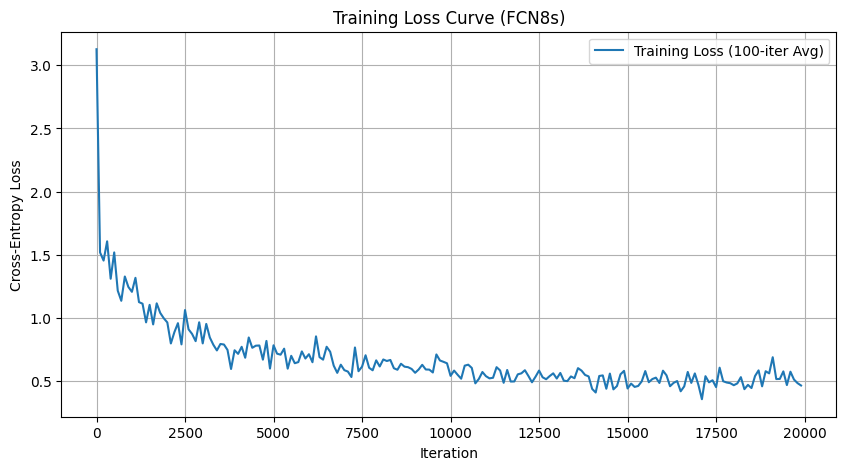


===== 3. Qualitative Result: Segmentation Visualization =====


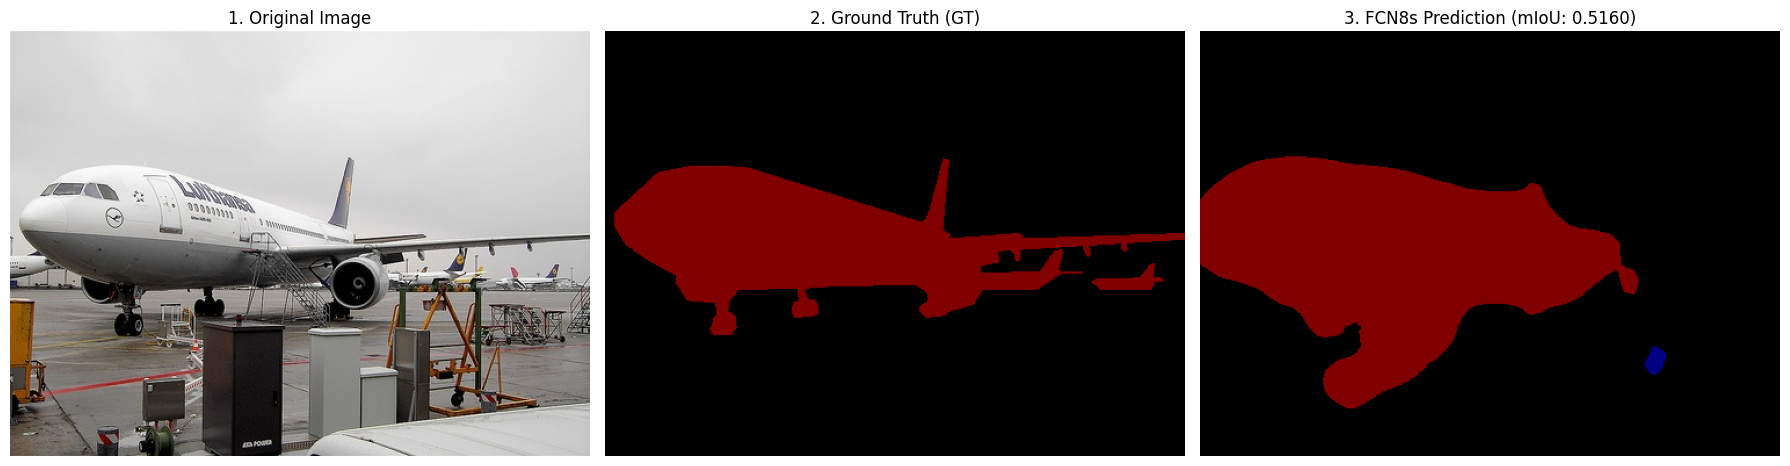

Segmentation 시각화 완료.


In [ ]:
def perform_analysis(model, loss_history,
                     test_img_file='2007_000033', # 파일 이름만 지정
                     img_dir='./lab/img',
                     gt_dir='./lab/gt'):
    """
    학습된 모델을 사용하여 정량적/정성적 결과를 도출하는 메인 함수
    Ground Truth를 포함하여 시각화함
    """

    # 1. 정량적 결과: Mean IoU 계산 및 출력
    print("===== 1. Quantitative Result: Mean IoU =====")
    model.cuda()
    model.eval()
    m_iou = validation_miou(model)

    # 2. 학습 과정 분석: Loss 변화 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(loss_history)) * 100, loss_history, label='Training Loss (100-iter Avg)')
    plt.title('Training Loss Curve (FCN8s)')
    plt.xlabel('Iteration')
    plt.ylabel('Cross-Entropy Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 3. 정성적 결과: 특정 이미지에 대한 Segmentation 시각화
    print("\n===== 3. Qualitative Result: Segmentation Visualization =====")

    test_img_path = os.path.join(img_dir, test_img_file + '.jpg')
    gt_path = os.path.join(gt_dir, test_img_file + '.png')

    try:
        # 원본 이미지 로드 (BGR)
        original_img = cv2.imread(test_img_path)
        # Ground Truth 라벨 로드 (그레이스케일)
        ground_truth_mask = cv2.imread(gt_path, 0)

        if original_img is None or ground_truth_mask is None: raise FileNotFoundError
    except FileNotFoundError:
        print(f"Error: {test_img_file} 이미지 또는 GT 파일을 찾을 수 없습니다. 시각화를 건너뜁니다.")
        return

    # a. 모델 예측 결과 도출
    test_img_processed = original_img.copy().astype(float)
    test_img_processed[:, :, 0] -= 104.008
    test_img_processed[:, :, 1] -= 116.669
    test_img_processed[:, :, 2] -= 122.675

    data = torch.from_numpy(test_img_processed.transpose((2, 0, 1))).float().cuda().unsqueeze(0)

    with torch.no_grad():
        score = model(data)

    output = score.cpu().data[0].numpy().transpose(1, 2, 0)
    prediction_mask = np.argmax(output, axis=2)

    # b. 예측 마스크와 GT 마스크를 컬러 이미지로 변환
    vis_prediction = decode_labels(prediction_mask)
    vis_ground_truth = decode_labels(ground_truth_mask)

    # c. Matplotlib으로 3개 이미지 시각화
    plt.figure(figsize=(18, 6))

    # 1. Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('1. Original Image')
    plt.axis('off')

    # 2. Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(vis_ground_truth)
    plt.title('2. Ground Truth (GT)')
    plt.axis('off')

    # 3. Model Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(vis_prediction)
    plt.title(f'3. FCN8s Prediction (mIoU: {m_iou:.4f})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("Segmentation 시각화 완료.")

# Main Execution Block
model.eval()
perform_analysis(model, loss_history)

### *References*
[1] FCN official code (https://github.com/shelhamer/fcn.berkeleyvision.org)

[2] Upsampling method (https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)

[3] Cs231n (http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)